In [24]:
%pip install statsbombpy

Note: you may need to restart the kernel to use updated packages.


In [28]:
import warnings
warnings.filterwarnings("ignore", message="credentials were not supplied")

import os, time, math
import pandas as pd
import numpy as np
from statsbombpy import sb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [29]:
def download_full_season_events(comp_id, season_id, out_dir='match_events'):
    print(f"Fetching matches for competition_id={comp_id}, season_id={season_id}...")
    matches = sb.matches(competition_id=comp_id, season_id=season_id)
    matches['match_date'] = pd.to_datetime(matches['match_date'])
    print(f"Total matches: {len(matches)}")
    
    os.makedirs(out_dir, exist_ok=True)
    dfs = []
    
    for _, row in matches.iterrows():
        mid = row.match_id
        home = row.home_team
        away = row.away_team
        home_name = home['name'] if isinstance(home, dict) else home
        away_name = away['name'] if isinstance(away, dict) else away
        
        print(f"Downloading events for {home_name} vs {away_name} (ID={mid})")
        try:
            ev = sb.events(match_id=mid, flatten_attrs=True)
            ev['match_date'] = row.match_date
            ev['home_team']   = home_name
            ev['away_team']   = away_name
            dfs.append(ev)
            time.sleep(0.5)
        except Exception as e:
            print(f" ➜ Error processing match {mid}: {e}")
    
    all_events = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    return all_events

COMP_ID, SEASON_ID = 2, 27
events_df = download_full_season_events(COMP_ID, SEASON_ID)
print(f"Total events downloaded: {len(events_df)}")

Fetching matches for competition_id=2, season_id=27...
Total matches: 380


Total events downloaded: 1313783


In [30]:
if 'team.name' in events_df.columns:
    base_team = events_df['team.name']
elif 'possession_team.name' in events_df.columns:
    base_team = events_df['possession_team.name']
else:
    base_team = pd.Series([None]*len(events_df), index=events_df.index)

team_series   = base_team.fillna(events_df['home_team']).fillna(events_df['away_team'])
player_series = events_df.get('player.name', pd.Series([None]*len(events_df), index=events_df.index))
coords        = events_df['location'].apply(lambda loc: loc if isinstance(loc, list) and len(loc)==2 else [np.nan, np.nan])
x_raw, y_raw  = coords.str[0], coords.str[1]

new_cols = pd.DataFrame({
    'team_name':   team_series,
    'player_name': player_series,
    'x_raw':       x_raw,
    'y_raw':       y_raw
}, index=events_df.index)

events_df = pd.concat([events_df, new_cols], axis=1)
events_df = events_df.loc[:, ~events_df.columns.duplicated()]

if 'minute' in events_df.columns and 'second' in events_df.columns:
    events_df['event_time'] = events_df['minute']*60 + events_df['second']
elif 'timestamp' in events_df.columns:
    ts = pd.to_datetime(events_df['timestamp'], errors='coerce')
    events_df['event_time'] = (ts.dt.hour*3600 + ts.dt.minute*60 +
                               ts.dt.second + ts.dt.microsecond/1e6)
else:
    events_df['event_time'] = np.nan
events_df['event_time'] = events_df['event_time'].astype(float)

def normalize_period(p):
    try: p = int(p)
    except: p = 1
    return p if p<=2 else (1 if p%2==1 else 2)

def adjust_location(row):
    x, y = row['x_raw'], row['y_raw']
    if pd.isna(x) or pd.isna(y):
        return pd.Series([np.nan, np.nan])
    p = normalize_period(row.get('period',1))
    team, home, away = row['team_name'], row['home_team'], row['away_team']
    if (p==1 and team==away) or (p==2 and team==home):
        x = 120 - x
    return pd.Series([x, y])

events_df[['x','y']] = events_df.apply(adjust_location, axis=1)

In [31]:
FINAL_THIRD_X = 80
press_df = (events_df
            .loc[(events_df['type']=='Pressure') & (events_df['x']>=FINAL_THIRD_X),
                 ['match_id','team_name','event_time','x','y','id']]
            .rename(columns={'event_time':'press_time','id':'press_id'}))
reco_df  = (events_df
            .loc[events_df['type']=='Ball Recovery',
                 ['match_id','team_name','event_time','x','y','id']]
            .rename(columns={'event_time':'rec_time','id':'rec_id'}))

In [32]:
press_df.dropna(subset=['press_time'], inplace=True)
reco_df.dropna(subset=['rec_time'], inplace=True)
press_df['press_time'] = press_df['press_time'].astype(float)
reco_df['rec_time']     = reco_df['rec_time'].astype(float)
press_df.sort_values(['match_id','team_name','press_time'], inplace=True)
reco_df.sort_values(['match_id','team_name','rec_time'], inplace=True)

In [33]:
TIME_WINDOW = 1.0
linked = []
for (mid, team), rg in reco_df.groupby(['match_id','team_name']):
    pg = press_df[(press_df['match_id']==mid) & (press_df['team_name']==team)]
    if pg.empty: continue
    tmp = pd.merge_asof(rg, pg,
                        left_on='rec_time', right_on='press_time',
                        by=['match_id','team_name'],
                        tolerance=TIME_WINDOW,
                        direction='backward',
                        suffixes=('_rec','_press'))
    linked.append(tmp)
linked = pd.concat(linked, ignore_index=True)

In [34]:
valid = linked.dropna(subset=['x_press']).copy()
valid['time_diff'] = valid['rec_time'] - valid['press_time']
valid['distance']  = valid.apply(lambda r: math.hypot(r['x_rec']-r['x_press'],
                                                     r['y_rec']-r['y_press']), axis=1)
unique_recov = valid.drop_duplicates(subset=['rec_id'])

In [35]:
press_ct       = press_df.groupby(['match_id','team_name']).size().rename('press_count')
press_with_rec = unique_recov.groupby(['match_id','team_name'])['press_id'].nunique().rename('press_with_recovery')
metrics_df     = pd.concat([press_ct, press_with_rec], axis=1).fillna(0).astype(int).reset_index()

In [36]:
press_total    = metrics_df.groupby('team_name')['press_count'].sum().rename('total_presses')
pres_rec_total = metrics_df.groupby('team_name')['press_with_recovery'].sum().rename('total_with_recovery')
avg_stats      = unique_recov.groupby('team_name').agg(avg_time_diff=('time_diff','mean'),
                                                      avg_distance=('distance','mean'))
teams = pd.concat([press_total, pres_rec_total, avg_stats], axis=1).fillna(0)
teams['conversion_rate']   = teams['total_with_recovery']/teams['total_presses']
teams['presses_per_match'] = teams['total_presses']/38

In [40]:
points = {
    'Leicester City':81,'Arsenal':71,'Tottenham Hotspur':70,'Manchester City':66,
    'Manchester United':66,'West Ham United':62,'Southampton':63,'Liverpool':60,
    'Chelsea':50,'AFC Bournemouth':42,'Crystal Palace':42,'Everton':47,
    'West Bromwich Albion':43,'Watford':45,'Stoke City':51,'Swansea City':47,
    'Newcastle United':37,'Sunderland':39,'Norwich City':34,'Aston Villa':17
}
teams['points'] = teams.index.map(points)

print("Team-level summary:")
print(teams)
print("\nDescriptive statistics:")
print(teams.describe())

corr_matrix = teams[['total_presses','conversion_rate','presses_per_match','points']].corr()
print("\nCorrelation matrix:")
print(corr_matrix)
pr_press, _ = pearsonr(teams['total_presses'], teams['points'])
pr_conv, _ = pearsonr(teams['conversion_rate'], teams['points'])
print(f"Pearson corr (press vs points): {pr_press:.2f}")
print(f"Pearson corr (conv rate vs points): {pr_conv:.2f}")

Team-level summary:
                      total_presses  total_with_recovery  avg_time_diff  \
team_name                                                                 
AFC Bournemouth                1721                  160       0.347561   
Arsenal                        1607                  185       0.347150   
Aston Villa                    1596                  184       0.303191   
Chelsea                        1716                  204       0.421801   
Crystal Palace                 1564                  191       0.409091   
Everton                        1461                  178       0.372973   
Leicester City                 1678                  192       0.397959   
Liverpool                      1666                  173       0.363128   
Manchester City                1566                  184       0.415789   
Manchester United              1696                  192       0.358209   
Newcastle United               1778                  213       0.419355   
Norwi

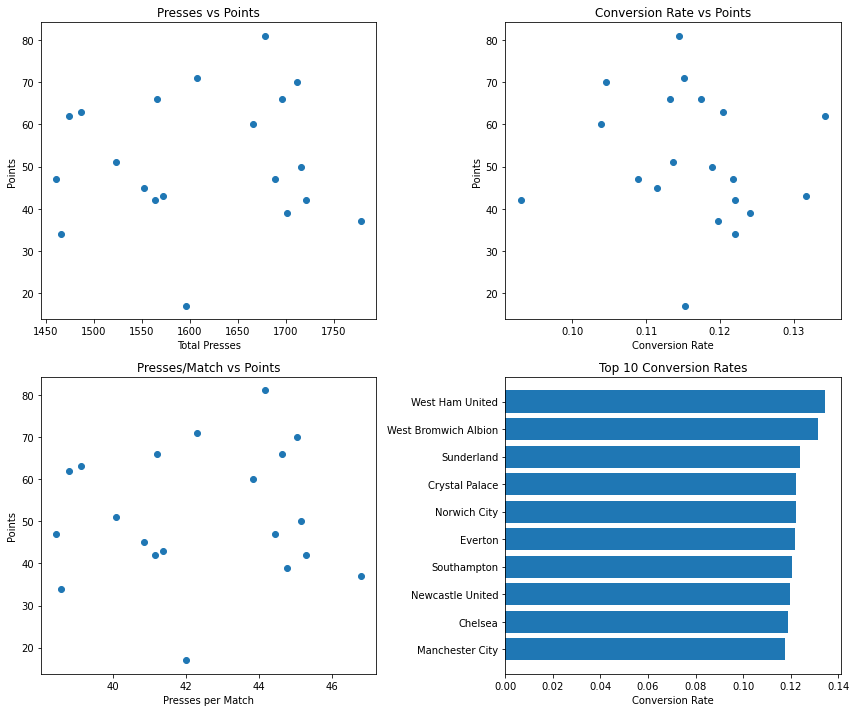

In [41]:
fig, axs = plt.subplots(2,2, figsize=(12,10))

axs[0,0].scatter(teams['total_presses'], teams['points'])
axs[0,0].set(title='Presses vs Points', xlabel='Total Presses', ylabel='Points')

axs[0,1].scatter(teams['conversion_rate'], teams['points'])
axs[0,1].set(title='Conversion Rate vs Points', xlabel='Conversion Rate', ylabel='Points')

axs[1,0].scatter(teams['presses_per_match'], teams['points'])
axs[1,0].set(title='Presses/Match vs Points', xlabel='Presses per Match', ylabel='Points')

top10 = teams.sort_values('conversion_rate', ascending=False).head(10)
axs[1,1].barh(top10.index, top10['conversion_rate'])
axs[1,1].invert_yaxis()
axs[1,1].set(title='Top 10 Conversion Rates', xlabel='Conversion Rate')

plt.tight_layout()
plt.show()

In [42]:
X = metrics_df[['press_count']]
y = metrics_df['press_with_recovery']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
print("Random Forest R²:", rf.fit(X_train, y_train).score(X_test, y_test))

Random Forest R²: 0.3695311627832719
